In [1]:
# Dataset has already been downloaded
'''
!curl -0 https://www.kaggle.com/datasets/kylegraupe/skin-cancer-binary-classification-dataset/download?datasetVersionNumber=1
'''

'\n!curl -0 https://www.kaggle.com/datasets/kylegraupe/skin-cancer-binary-classification-dataset/download?datasetVersionNumber=1\n'

In [3]:
# Unzip
#!unzip -q ../../archive.zip

In [4]:
# Explore the structure of the file after unzipping
!ls ../../Skin_Data

Cancer	Non_Cancer  Test  Train


In [6]:
!ls ../../Skin_Data/Cancer
!ls ../../Skin_Data/Non_Cancer
!ls ../../Skin_Data/Test
!ls ../../Skin_Data/Train

Testing  Training
Testing  Training
Cancer	Non_Cancer
Cancer	Non_Cancer


### Select dataset
I've selected the Skin Cancer Binary Classification dataset. It has 84 Cancer images (42 Testing, and 42 Training), and it has 204 Non-Cancer images (162 Testing, and 42 Training).

### Setup the dataset for a demonstration of transfer learning

In [8]:
# Load packages
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-04-30 21:30:25.521353: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 21:30:25.585989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 21:30:25.586114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 21:30:25.589203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 21:30:25.604645: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 21:30:25.605982: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [9]:
# delete corrupted images from cancer and Non-cancer training sets
num_skipped = 0
for folder_name in ("Cancer", "Non_Cancer"):
    folder_path = os.path.join("../../Skin_Data/Train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [12]:
# Count the number of corrupted images in the each of the testing sets without deleting
num_skipped = 0
for folder_name in ("Cancer", "Non_Cancer"):
    folder_path = os.path.join("../../Skin_Data/Test", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            #os.remove(fpath)

print(f"Counted {num_skipped} images.")

Counted 0 images.


In [13]:
# Generate a dataset

image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "../../Skin_Data/Train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 84 files belonging to 2 classes.
Using 68 files for training.
Using 16 files for validation.


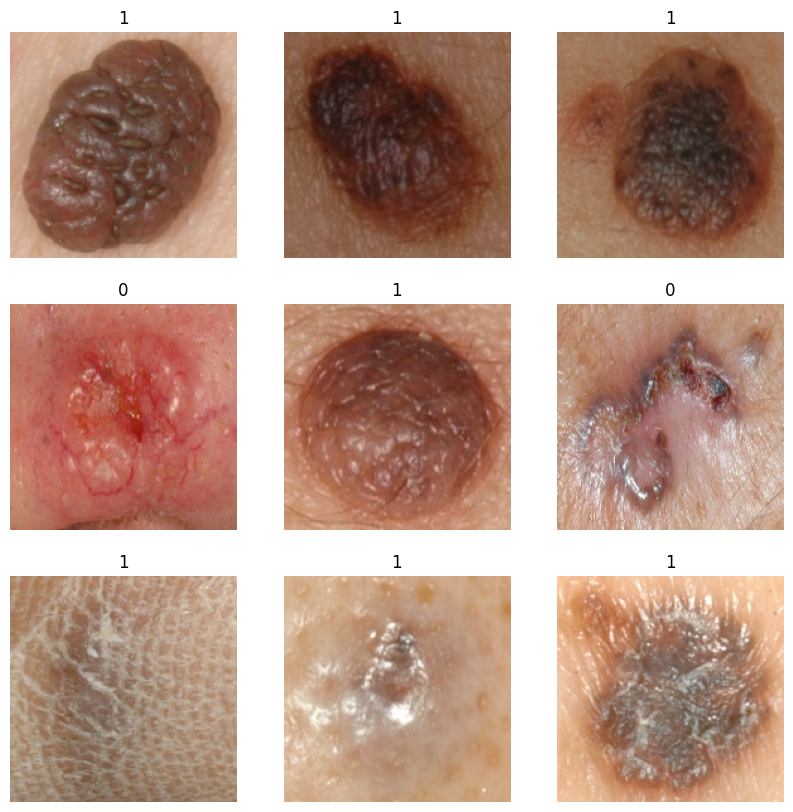

In [14]:
# Visualize the image data

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
# Augment the data through random aleterations of the images using horizontal random flip, and a random rotation witha factor of (-0.1,0.1)

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

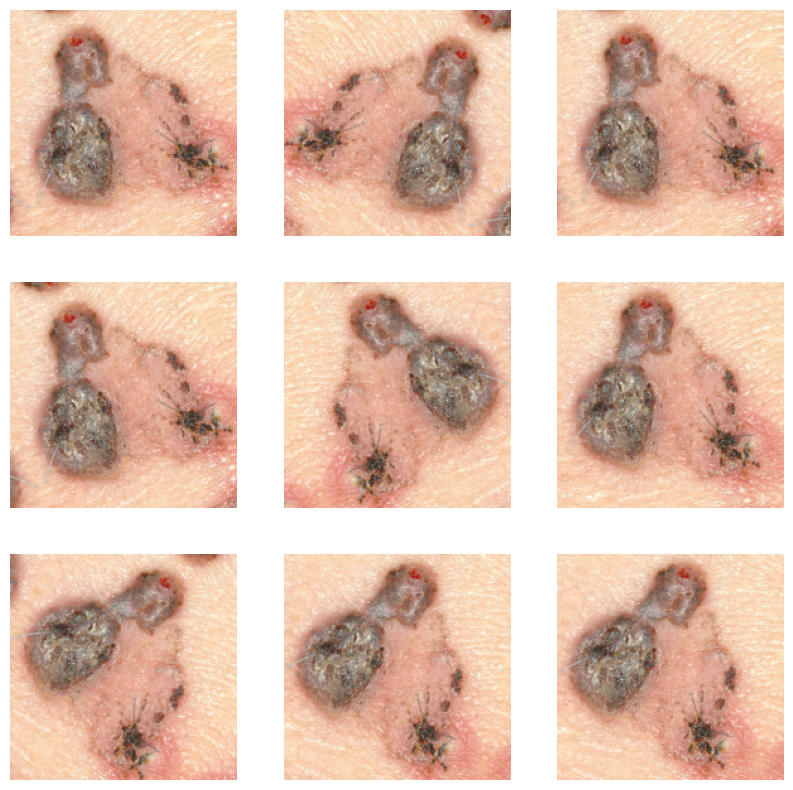

In [16]:
# Visualize some augmented samples

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

### Standardizing the data
Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

Since my machine is old, and the hardware does not easily support GPU acceleration, we will use option 2.
Option 2: apply `data_augmentation` preprocessor to the dataset, so as to obtain a dataset that yields batches of augmented images
- With this option, our data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

- If we're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.


In [17]:
# Apply `data_augmentation` to the training images.
# We make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

### Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using [KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

### Create Module for the Data Loader

In [20]:
import os
import keras
from keras import layers
from tensorflow import data as tf_data

# Function to delete corrupted images
def clean_data(directory):
    num_skipped = 0
    for folder_name in ("Cancer", "Non_Cancer"):
        folder_path = os.path.join(directory, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = b"JFIF" in fobj.peek(10)
            finally:
                fobj.close()
            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)
    print(f"Deleted {num_skipped} corrupted images from {directory}")

# Function to create datasets
def create_datasets(base_dir, image_size=(180, 180), batch_size=128, validation_split=0.2, seed=1337):
    train_ds, val_ds = keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=validation_split,
        subset="both",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
    )
    return train_ds, val_ds

# Data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

# Function to apply data augmentation
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Function to prepare datasets with augmentation and prefetching
def prepare_datasets(train_ds, val_ds):
    train_ds = train_ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
    return train_ds, val_ds

